In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import bartlett
import seaborn as sns
import scipy.stats as stats
# import shap
#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
#요일
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

In [4]:
def windstrength_equal(clusters):
    # 가장 자주 사용하는 windstrength mode가 smart user와 동일한가
    df1=pd.DataFrame(smart_dehum_user['airstate.windstrength'].value_counts()).sort_index()
    temp = []
    for c in clusters:
        df2=pd.DataFrame(c['airstate.windstrength'].value_counts()).sort_index()
        if int(df1.idxmax()) == int(df2.idxmax()):
            temp.append(c)
    clusters=temp
    return clusters

In [5]:
# funtion to find NoSmart dehum group
def ttest_find_NoSmart(clusters):
    NoSmart = []
    # 가장 자주 사용하는 windstrength mode가 smart user와 동일한가
    df1=pd.DataFrame(smart_dehum_user['airstate.windstrength'].value_counts()).sort_index()
    temp = []
    for c in clusters:
        df2=pd.DataFrame(c['airstate.windstrength'].value_counts()).sort_index()
        if int(df1.idxmax()) == int(df2.idxmax()):
            temp.append(c)
    clusters=temp

    for c in clusters:
        c1 = daysum_df(c)
        vt1 = bartlett(smart_dehum_user_daysum['energywatt'],c1['energywatt'])[1] # 등분산검정
        if vt1 < 0.05: # 두 그룹은 이분산성
            tvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=False)[0]
            pvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=False)[1]/2
        else:
            tvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=True)[0]
            pvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=True)[1]/2
        # 일일 에너지소모량 합의 평균이 스마트 그룹보다 큰가
        if (pvalue1 < 0.05) & (tvalue1 > 0): # 즉 앞의 그룹의 평균이 더 큼
            vt2 = bartlett(smart_dehum_user['humidity'],c['humidity'])[1] # 등분산검정
            if vt2 < 0.05: # 두 그룹은 이분산성
                tvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=False)[0]
                pvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=False)[1]/2
            else:
                tvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=True)[0]
                pvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=True)[1]/2
            # 시간별 습도의 평균이 스마트 그룹보다 큰가
            if (pvalue2 < 0.05) & (tvalue2 > 0): # 두 조건모두 스마트 그룹보다 클때
                NoSmart.append(c)
            else: continue
        else: continue
    return NoSmart

In [6]:
# 전처리
def resample_df(df):
    df = df.set_index(['create_dt'])
    df1 = df[['humidity','currenttemperature', 
          'airstate.tempstate.target', 'pm1', 'pm2', 'pm10','sensory_temp','DI']]
    df2 = df[['airstate.opmode', 'airstate.windstrength',
           'airstate.opmode2','day','hour','weekday','weekend','Clid']]
    df3 = df['energywatt']
    df1 = df1.resample('H').mean()
    df2 = df2.resample('H').first()
    df3 = df3.resample('H').sum() / df3.resample('H').count()
    df3 = df3.replace(0, np.NaN)
    df1 = df1.interpolate(method='time')
    df2 = df2.interpolate(method='nearest')
#     df3 = df3.interpolate(method='spline',order=3)
    df2 = df2.astype('int')
    df = pd.concat([df1,df2,df3],axis=1)
    return df

In [7]:
# 시계열 분해 시각화
def vis_time_series_decompose(df,col_name):
    df=df.set_index(['create_dt'])
    df = df.resample('H').mean()
    df = df.interpolate(method='linear')
    res = sm.tsa.seasonal_decompose(df[col_name], model='additive')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

In [8]:
all_df = pd.read_csv('all_data.csv')
dep_genes = pd.read_csv('DEP_genes.dat',sep='\t') # 클러스터 info

all_df = pd.merge(all_df,dep_genes,left_on='device_id_deidentification',right_on='GeneID',how='left')
all_df.dropna(subset=['Type'],inplace=True)

all_df['device_id_deidentification']=all_df['device_id_deidentification'].str[8:]
all_df['Clid'] = all_df['Clid'].astype(int)
all_df['create_dt'] = pd.to_datetime(all_df['create_dt']) # datetime으로 변경
all_df = all_df.drop(['GeneID', 'Type','airstate.miscfuncstate.uvnano','airstate.miscfuncstate.filtercleanauto'], axis=1) # 필요없는 칼럼 삭제

In [9]:
# create_dt 월 일 시간 주말 평일로 변환
all_df['month'] = all_df['create_dt'].dt.month
all_df['day'] = all_df['create_dt'].dt.day
all_df['hour'] = all_df['create_dt'].dt.hour
all_df['minute'] = all_df['create_dt'].dt.minute
all_df['weekday'] = all_df['create_dt'].dt.weekday
# all_df['weekday'] = all_df['create_dt'].apply(weekday)
all_df['weekend'] = all_df['create_dt'].apply(weekend)
all_df['date'] = all_df['create_dt'].dt.date

In [10]:
# 체감온도 변수 생성
all_df['sensory_temp']=13.12+0.6215*all_df['currenttemperature']-13.947*all_df['airstate.windstrength']**0.16+0.486*all_df['currenttemperature']*all_df['airstate.windstrength']**0.16
all_df['DI'] = 0.81*all_df['currenttemperature'] + 0.01*all_df['humidity']*(0.99*all_df['currenttemperature']-14.3)+46.3

In [10]:
from tqdm import tqdm

device_info = all_df.groupby('device_id_deidentification')['energywatt'].sum().index

device_lst = []
for name in tqdm(device_info):
    df = all_df.loc[all_df['device_id_deidentification']==name]
    df = resample_df(df)
    df['currenttemperature'] = df['currenttemperature'].round(0)
    df['airstate.tempstate.target'] = df['airstate.tempstate.target'].round(0)
    df['prior_humidity'] = df['humidity'].shift(1)
    df['diff_humidity'] = df['humidity']-df['prior_humidity']
    df['diff_temp'] = df['currenttemperature'] - df['currenttemperature'].shift(1)
    device_lst.append(df)

100%|███████████████████████████████████████████████████████████████| 2233/2233 [08:21<00:00,  4.46it/s]


In [12]:
# df = resample_df(df)
# df['currenttemperature'] = df['currenttemperature'].round(0)
# df['airstate.tempstate.target'] = df['airstate.tempstate.target'].round(0)
# df['prior_humidity'] = df['humidity'].shift(1)
# df['diff_humidity'] = df['humidity']-df['prior_humidity']
# df['diff_temp'] = df['currenttemperature'] - df['currenttemperature'].shift(1)

In [11]:
# condition = (df['currenttemperature']<=df['airstate.tempstate.target'])&(df['airstate.opmode']==1)&(df['diff_temp']==0)&(df['diff_humidity']>=1)
# df.loc[(df['currenttemperature']<=df['airstate.tempstate.target'])&(df['airstate.opmode']==1)&(df['diff_temp']==0)&(df['diff_humidity']>=1)]
for df in tqdm(device_lst):
    df['inefficiency'] = 0
    condition1 = (df['currenttemperature']<=df['airstate.tempstate.target'])&(df['airstate.opmode']==1)&(df['diff_temp']==0)&(df['diff_humidity']<1)
    condition2 = (df['currenttemperature']<=df['airstate.tempstate.target'])&(df['airstate.opmode']==1)&(df['diff_temp']==0)&(df['diff_humidity']>=1)
    df.loc[condition1,'inefficiency']=1
    df.loc[condition2,'inefficiency']=2

100%|██████████████████████████████████████████████████████████████| 2233/2233 [00:05<00:00, 407.45it/s]


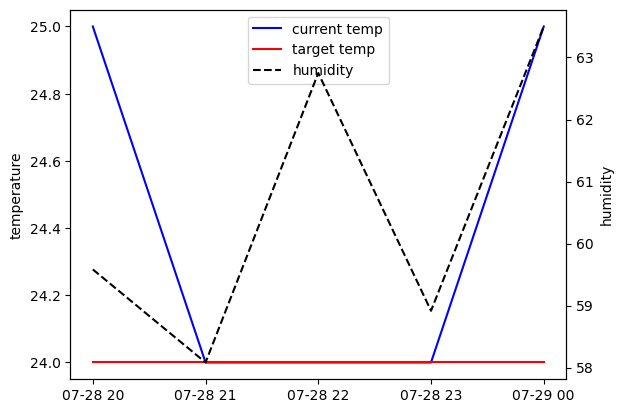

In [13]:
from datetime import timedelta
from matplotlib import dates

d = device_lst[556]
ineffi_index=d.loc[d['inefficiency']==2].index
idx=pd.date_range(start=ineffi_index[4]-timedelta(hours = 2),end=ineffi_index[4]+timedelta(hours = 2),freq='H')
dd = d.loc[idx,:]
fig,ax1 = plt.subplots()
l1 = ax1.plot(dd.index,dd['currenttemperature'],color='b',label = 'current temp')
l2 = ax1.plot(dd.index,dd['airstate.tempstate.target'],color='r',label = 'target temp')
ax1.set_ylabel('temperature')

ax2 = ax1.twinx()
l3 = ax2.plot(dd.index,dd['humidity'],'--',color='black',label='humidity')
ax2.set_ylabel('humidity')

ln = l1+l2+l3
labs = [l.get_label() for l in ln]
ax1.legend(ln, labs, loc=0)

ax1.xaxis.set_major_locator(dates.HourLocator(interval=1))
plt.show()

In [14]:
con_df = pd.DataFrame()
# pd.concat([device_lst[0],device_lst[1]],axis=0)
for dev in tqdm(device_lst):
    con_df=pd.concat([con_df,dev],axis=0)

100%|██████████████████████████████████████████████████████████████| 2233/2233 [00:21<00:00, 105.21it/s]


In [39]:
234/(2175+234) # 0.0971
3014/(20864+3014) # 0.126

0.12622497696624507

In [40]:
inefficiency_clid = pd.DataFrame(con_df.groupby('Clid')['inefficiency'].value_counts())
inefficiency_clid.rename(columns = {'inefficiency':'rate'},inplace=True)
inefficiency_clid = inefficiency_clid.reset_index()
inefficiency_clid = inefficiency_clid.loc[inefficiency_clid['inefficiency'].isin([1,2])]
inefficiency_clid=inefficiency_clid.reset_index(drop=True)
sum_=inefficiency_clid.groupby('Clid')['rate'].sum().values
lst = np.arange(1,33,2)

for i in lst:
    inefficiency_clid.iloc[i,2] = inefficiency_clid.iloc[i,2]/(inefficiency_clid.iloc[i-1,2]+inefficiency_clid.iloc[i,2])
inefficiency_clid


,Clid,inefficiency,rate
0,1,1,2175.000000
1,1,2,0.097136
2,2,1,20864.000000
3,2,2,0.126225
4,3,1,32082.000000
5,3,2,0.128254
6,4,1,260.000000
7,4,2,0.037037
8,5,1,359.000000
9,5,2,0.137019


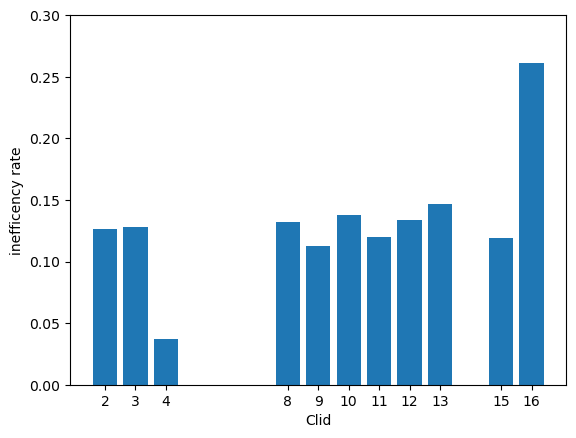

In [44]:
kk=inefficiency_clid.loc[inefficiency_clid['inefficiency']==2]
clid = [2,3,4,8,9,10,11,12,13,15,16]
kk = kk.loc[kk['Clid'].isin(clid)]

plt.bar(kk['Clid'],kk['rate'])
plt.xticks(clid)
plt.ylim(0,0.3)
plt.xlabel('Clid')
plt.ylabel('inefficency rate')
plt.show()

In [11]:
# 제습모드를 잘 활용하고 있는 군집
smart_dehum_user = all_df.loc[all_df['Clid'].isin([1,7,14])]
# 제습모드를 항상켜놓고 있는 군집
always_dehum_user = all_df.loc[all_df['Clid'].isin([5,6])]
# 제습모드를 잘 사용 못하는 군집
not_dehum_user = all_df.loc[all_df['Clid'].isin([11])]
# lst_user = [all_df,smart_dehum_user,always_dehum_user,not_dehum_user]
lst_user = [smart_dehum_user,always_dehum_user,not_dehum_user]

In [12]:
def plotting1_time(col):
    plt.plot(active_user_resampled.groupby('hour')[col].mean(),color='r',label='active user')
    plt.plot(nonactive_user_resampled.groupby('hour')[col].mean(),color='b',label='unused user')
    plt.plot(always_user_resampled.groupby('hour')[col].mean(),color='g',label='fulltime user')
    plt.plot(all_user_resampled.groupby('hour')[col].mean(),'--',color='black',label='all user')
#     plt.ylim(65,72)
    plt.xticks(np.arange(0,24))
    plt.grid()
    plt.legend()
    plt.title(f'comparison about {col}')
    plt.show()

In [13]:
# 기기별 일일 변수 합

def daysum_df(df) :
    temp = df.groupby(['device_id_deidentification','date']).sum()
    temp = pd.DataFrame(temp)
    return temp

In [14]:
active_user_resampled = resample_df(smart_dehum_user)
always_user_resampled = resample_df(always_dehum_user)
nonactive_user_resampled = resample_df(not_dehum_user)
all_user_resampled = resample_df(all_df)
lst_resampled = [all_user_resampled,active_user_resampled,always_user_resampled,nonactive_user_resampled]

In [16]:
active_user_resampled

,humidity,currenttemperature,airstate.tempstate.target,pm1,pm2,pm10,sensory_temp,DI,airstate.opmode,airstate.windstrength,airstate.opmode2,day,hour,weekday,weekend,Clid,energywatt
create_dt,,,,,,,,,,,,,,,,,
2021-07-01 09:00:00,67.770833,25.208333,25.125000,3.072917,3.114583,3.447917,27.773354,73.957965,0,1,1,1,9,3,0,1,35.479167
2021-07-01 10:00:00,66.625000,25.291667,25.041667,3.000000,3.031250,3.510417,27.907347,73.946253,0,1,1,1,10,3,0,1,36.510417
2021-07-01 11:00:00,65.468750,25.312500,25.468750,3.000000,3.020833,3.489583,27.933688,73.817447,0,0,1,1,11,3,0,1,32.989583
2021-07-01 12:00:00,65.968421,25.589474,25.505263,3.063158,3.073684,3.547368,28.008247,74.256315,0,0,1,1,12,3,0,1,22.884211
2021-07-01 13:00:00,64.364583,25.531250,25.791667,3.041667,3.062500,3.572917,27.937905,74.002277,0,0,1,1,13,3,0,1,25.510417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01 04:00:00,65.537859,25.712794,25.971279,1.018277,1.036554,1.138381,27.977786,74.461505,1,1,0,1,4,6,1,14,31.422977
2021-08-01 05:00:00,65.994778,25.691906,25.968668,1.010444,1.026110,1.156658,27.948902,74.483752,1,1,0,1,5,6,1,14,27.660574
2021-08-01 06:00:00,66.251309,25.651832,25.960733,0.984293,0.984293,1.089005,27.880820,74.456257,0,1,1,1,6,6,1,7,27.023560


In [15]:
# 일일 사용량합 df
all_df_daysum = daysum_df(all_df)
active_user_daysum = daysum_df(smart_dehum_user)
always_user_daysum = daysum_df(always_dehum_user)
nonactive_user_daysum = daysum_df(not_dehum_user)
lst_daysum = [all_df_daysum,active_user_daysum,always_user_daysum,nonactive_user_daysum]

/tmp/ipykernel_26017/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_26017/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_26017/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','

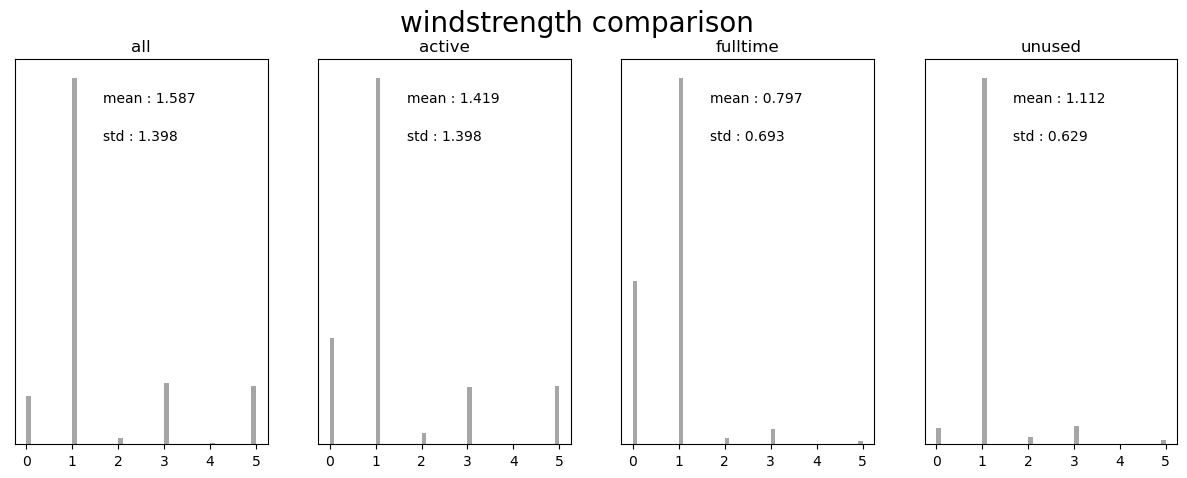

In [68]:
# WIND STRENGTH visualize
fig = plt.figure(figsize = (15, 5))
lst_name = ['all','active','fulltime','unused']
for i,r in enumerate(lst_resampled,start=1):
    ax = plt.subplot(1, 4, i)
    wind = r['airstate.windstrength']
    mean = round(wind.mean(),3)
    std = round(wind.std(),3)
#     max_idx = wind.idxmax()
    skew = (3*(mean - np.median(wind))/wind.std()).round(3)
    plt.hist(wind, alpha = 0.7, bins = 50, color = 'gray')   
#     plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_title(lst_name[i-1])
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
#     plt.text(0.35, 0.7, f'skew : {max_idx}',  ha='left', va='center', transform=ax.transAxes)

plt.suptitle('windstrength comparison',fontsize=20)
plt.show()

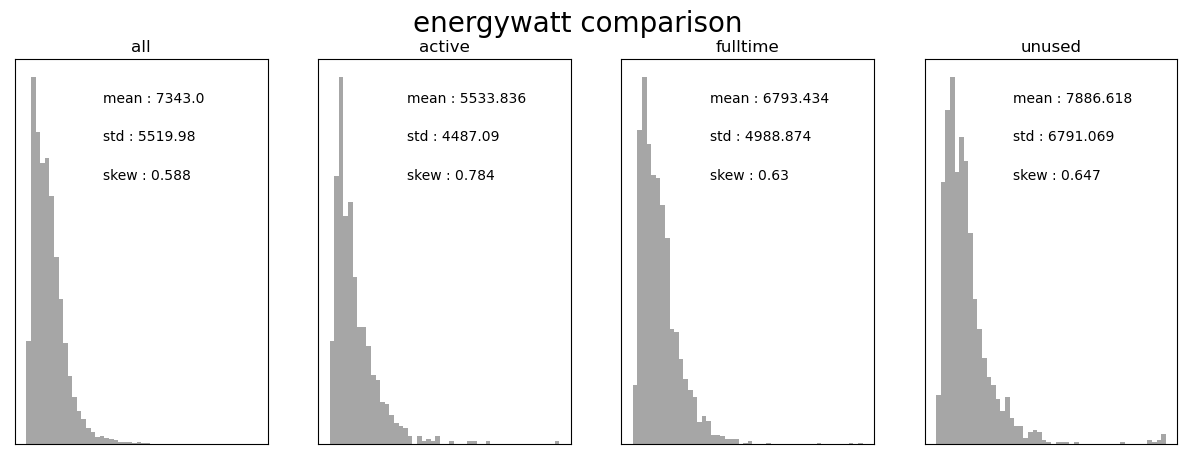

In [69]:
fig = plt.figure(figsize = (15, 5))
lst_name = ['all','active','fulltime','unused']
for i,r in enumerate(lst_daysum,start=1):
    ax = plt.subplot(1, 4, i)
    energy = r['energywatt'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')   
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_title(lst_name[i-1])
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)
plt.suptitle('energywatt comparison',fontsize=20)
plt.show()

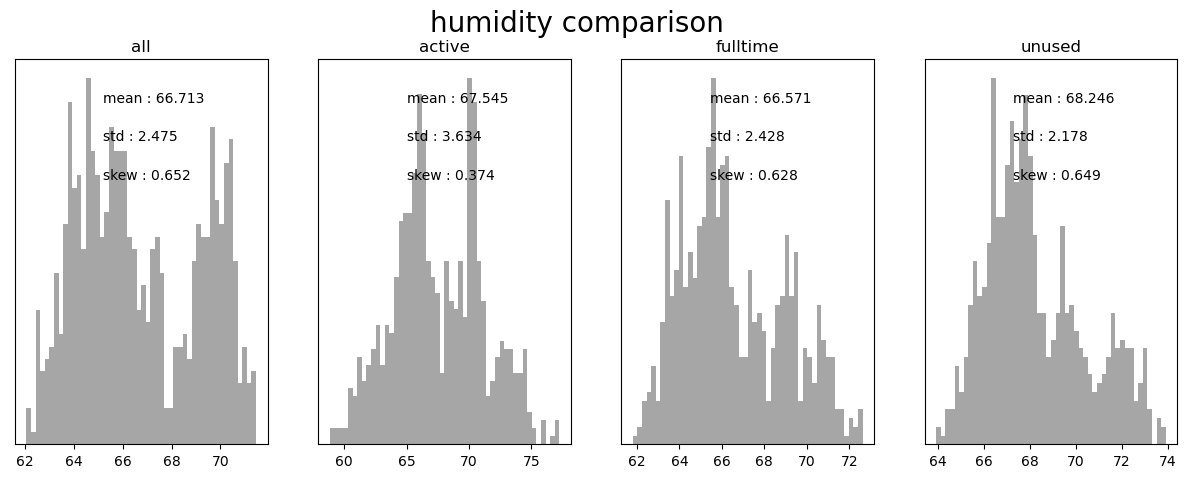

In [70]:
# humidity visualize
fig = plt.figure(figsize = (15, 5))
lst_name = ['all','active','fulltime','unused']
for i,r in enumerate(lst_resampled,start=1):
    ax = plt.subplot(1, 4, i)
    humidity = r['humidity'].values
    mean = humidity.mean().round(3)
    std = humidity.std().round(3)
    skew = (3*(mean - np.median(humidity))/humidity.std()).round(3)
    plt.hist(humidity, alpha = 0.7, bins = 50, color = 'gray')   
#     plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_title(lst_name[i-1])
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

plt.suptitle('humidity comparison',fontsize=20)    
plt.show()

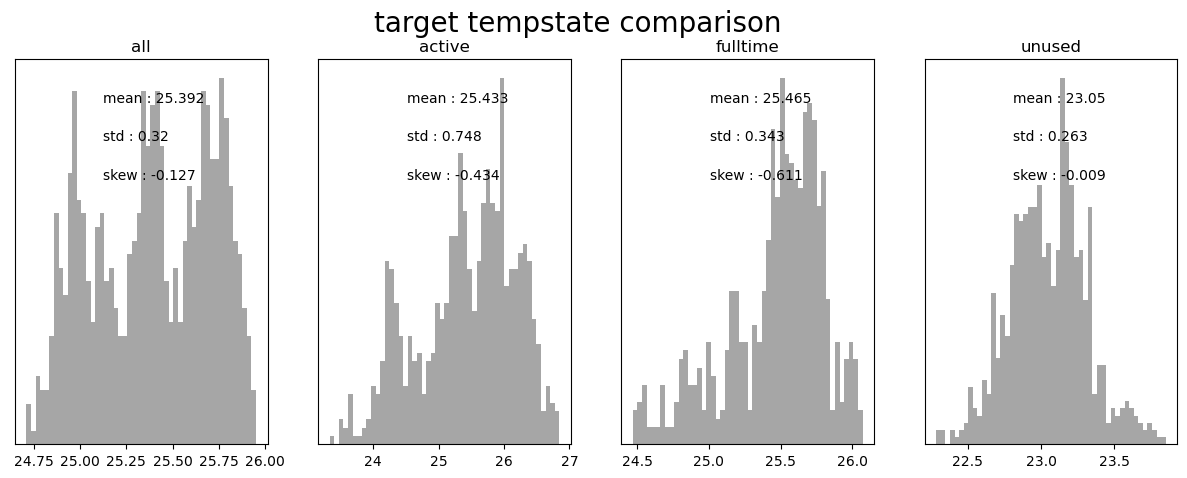

In [71]:
# humidity visualize
fig = plt.figure(figsize = (15, 5))
lst_name = ['all','active','fulltime','unused']
for i,r in enumerate(lst_resampled,start=1):
    ax = plt.subplot(1, 4, i)
    humidity = r['airstate.tempstate.target'].values
    mean = humidity.mean().round(3)
    std = humidity.std().round(3)
    skew = (3*(mean - np.median(humidity))/humidity.std()).round(3)
    plt.hist(humidity, alpha = 0.7, bins = 50, color = 'gray')   
#     plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_title(lst_name[i-1])
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

plt.suptitle('target tempstate comparison',fontsize=20)    
plt.show()

/tmp/ipykernel_17802/751439141.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['energywatt'].mean().reset_index().pivot('day', 'hour', 'energywatt')
/tmp/ipykernel_17802/751439141.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['energywatt'].mean().reset_index().pivot('day', 'hour', 'energywatt')
/tmp/ipykernel_17802/751439141.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['energywatt'].mean().reset_index().pivot('day', 'hour', 'energywatt')
/tmp/ipykernel_17802/751439141.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['energywatt'].mean().reset_index().pivot('day', 'hour', 'energywatt')


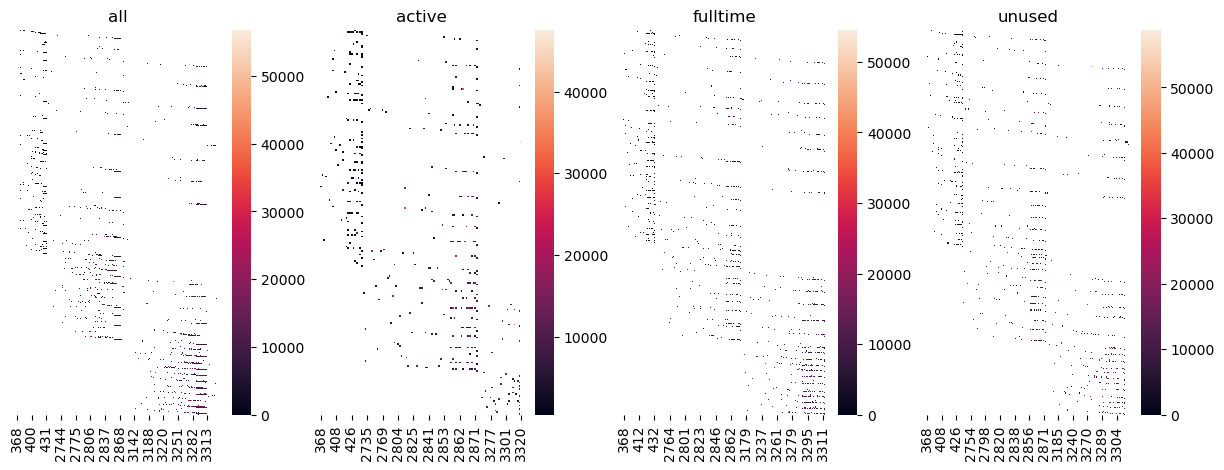

In [72]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 5))
for i,r in enumerate(lst_daysum,start=1):
    df = r
    df = df.groupby(['day', 'hour'])['energywatt'].mean().reset_index().pivot('day', 'hour', 'energywatt')
    plt.subplot(1, 4, i)
    sns.heatmap(df)
    plt.title(lst_name[i-1])
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [73]:
active_user_daysum

airstate.opmode  \
device_id_deidentification                         date                          
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08              103   
                                                   2021-07-09              107   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21               22   
                                                   2021-07-22               97   
                                                   2021-07-24              135   
...                                                                        ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18              108   
                                                   2021-07-26               25   
                                                   2021-07-27               57   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405... 2021-07-17              120   
                                                   2021-07-18              108   

                                                               energywatt  \
device_id_deidentification                         date                     
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08        4562   
                                                   2021-07-09         569   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21        7813   
                                                   2021-07-22        1621   
                                                   2021-07-24        5531   
...                                                                   ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18        2779   
                                                   2021-07-26        4990   
                                                   2021-07-27        2756   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405... 2021-07-17        5205   
                                                   2021-07-18        1756   

                                                               humidity  \
device_id_deidentification                         date                   
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08   12138.0   
                                                   2021-07-09    8155.0   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21   10591.0   
                                                   2021-07-22    7199.0   
                                                   2021-07-24   11779.0   
...                                                                 ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18    6853.0   
                                                   2021-07-26   11118.0   
                                                   2021-07-27    6396.0   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405... 2021-07-17   12502.0   
                                                   2021-07-18    8128.0   

                                                               airstate.windstrength  \
device_id_deidentification                         date                                
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08                    102   
                                                   2021-07-09                    107   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21                    174   
                                                   2021-07-22                    107   
                                                   2021-07-24                    180   
...                                                                              ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18                      0   
                                                   2021-07-26                    169   
                                                   2021-07-27                     46   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405...

/tmp/ipykernel_17802/4179336549.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['airstate.opmode2'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode2')
/tmp/ipykernel_17802/4179336549.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['airstate.opmode2'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode2')
/tmp/ipykernel_17802/4179336549.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['airstate.opmode2'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode2')


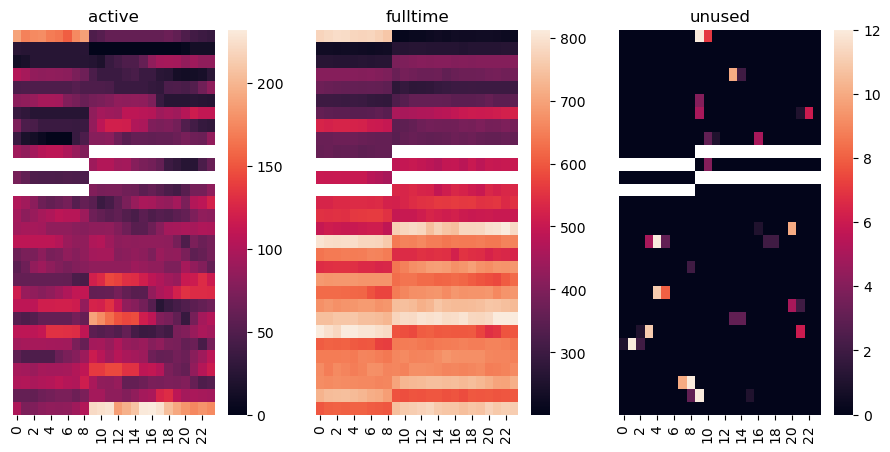

In [74]:
lst_name = ['active','fulltime','unused']
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 5))
for i,r in enumerate(lst_user,start=1):
    df = r
    df = df.groupby(['day', 'hour'])['airstate.opmode2'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode2')
    plt.subplot(1, 4, i)
    sns.heatmap(df)
    plt.title(lst_name[i-1])
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

/tmp/ipykernel_17802/538448382.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['airstate.opmode'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode')
/tmp/ipykernel_17802/538448382.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['airstate.opmode'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode')
/tmp/ipykernel_17802/538448382.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(['day', 'hour'])['airstate.opmode'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode')


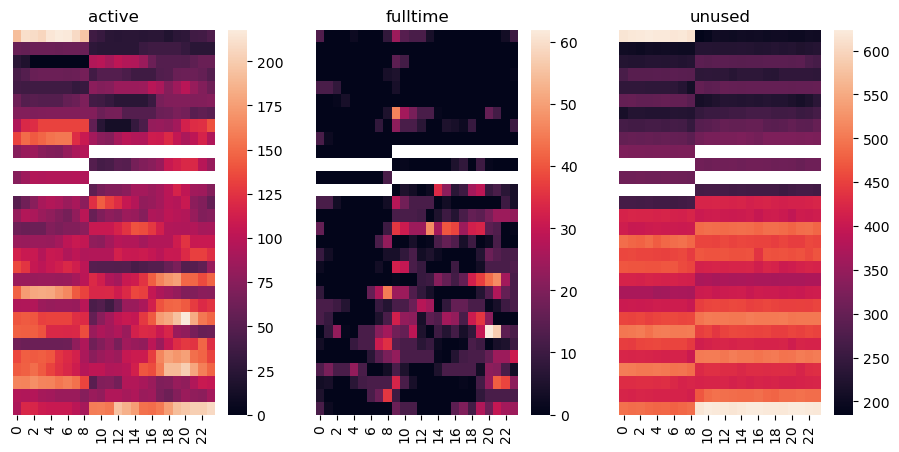

In [75]:
# energy usage of each building ~ weekday, hour
lst_name = ['active','fulltime','unused']
fig = plt.figure(figsize = (15, 5))
for i,r in enumerate(lst_user,start=1):
    df = r
    df = df.groupby(['day', 'hour'])['airstate.opmode'].sum().reset_index().pivot('day', 'hour', 'airstate.opmode')
    plt.subplot(1, 4, i)
    sns.heatmap(df)
    plt.title(lst_name[i-1])
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [76]:
len(smart_dehum_user)
len(always_dehum_user)

376516

In [77]:
smart_dehum_user

,device_id_deidentification,create_dt,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,pm1,pm2,...,Clid,month,day,hour,minute,weekday,weekend,date,sensory_temp,DI
3150,1bdbf6c82768fa0921c7fe0f923275d2fe73731be62a66...,2021-07-01 09:00:14,0,0,81.0,1,25.0,26.0,0.0,0.0,...,1,7,1,9,0,3,0,2021-07-01,26.8605,75.0145
3151,1bdbf6c82768fa0921c7fe0f923275d2fe73731be62a66...,2021-07-01 09:05:15,0,0,81.0,1,25.0,26.0,0.0,0.0,...,1,7,1,9,5,3,0,2021-07-01,26.8605,75.0145
3152,1bdbf6c82768fa0921c7fe0f923275d2fe73731be62a66...,2021-07-01 09:10:16,0,9,80.0,1,26.0,26.0,0.0,0.0,...,1,7,1,9,10,3,0,2021-07-01,27.9680,76.5120
3153,1bdbf6c82768fa0921c7fe0f923275d2fe73731be62a66...,2021-07-01 09:15:17,0,0,77.0,1,25.0,26.0,0.0,0.0,...,1,7,1,9,15,3,0,2021-07-01,26.8605,74.5965
3154,1bdbf6c82768fa0921c7fe0f923275d2fe73731be62a66...,2021-07-01 09:20:18,0,0,76.0,1,25.0,26.0,0.0,0.0,...,1,7,1,9,20,3,0,2021-07-01,26.8605,74.4920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595995,fa0afe78b4f122da18aec1a7a7d3f3049fe610668ece4e...,2021-08-01 08:39:26,0,0,68.0,0,25.0,26.0,0.0,0.0,...,7,8,1,8,39,6,1,2021-08-01,28.6575,73.6560
3595996,fa0afe78b4f122da18aec1a7a7d3f3049fe610668ece4e...,2021-08-01 08:44:26,0,65,68.0,0,25.0,26.0,0.0,0.0,...,7,8,1,8,44,6,1,2021-08-01,28.6575,73.6560
3595997,fa0afe78b4f122da18aec1a7a7d3f3049fe610668ece4e...,2021-08-01 08:49:26,0,0,67.0,0,24.0,26.0,0.0,0.0,...,7,8,1,8,49,6,1,2021-08-01,28.0360,72.0782
3595998,fa0afe78b4f122da18aec1a7a7d3f3049fe610668ece4e...,2021-08-01 08:54:26,0,0,68.0,0,25.0,26.0,0.0,0.0,...,7,8,1,8,54,6,1,2021-08-01,28.6575,73.6560


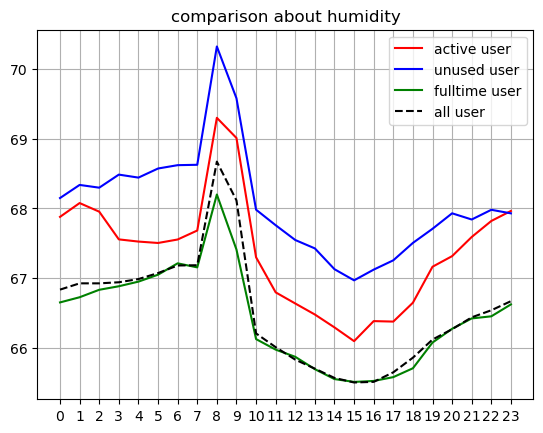

In [78]:
plotting1_time('humidity')

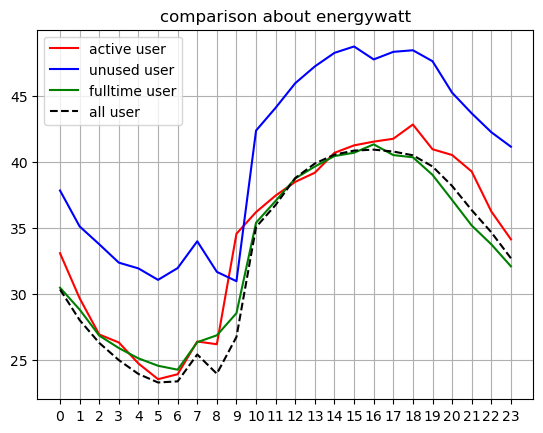

In [79]:
plotting1_time('energywatt') # all Plot 잘못됨

In [80]:
smart_dehum_user.columns

Index(['device_id_deidentification', 'create_dt', 'airstate.opmode',
       'energywatt', 'humidity', 'airstate.windstrength', 'currenttemperature',
       'airstate.tempstate.target', 'pm1', 'pm2', 'pm10', 'airstate.opmode2',
       'Clid', 'month', 'day', 'hour', 'minute', 'weekday', 'weekend', 'date',
       'sensory_temp', 'DI'],
      dtype='object')

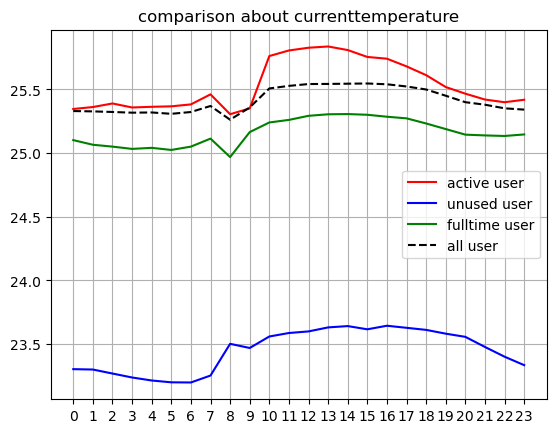

In [81]:
plotting1_time('currenttemperature')

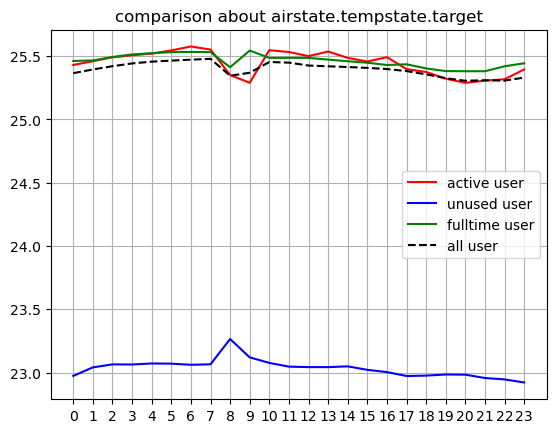

In [82]:
plotting1_time('airstate.tempstate.target') # 타겟온도가 nonactive useR 가 훨씬 낮다 -> 이게 에너지 과소모를 일으킬 가능성이 높다

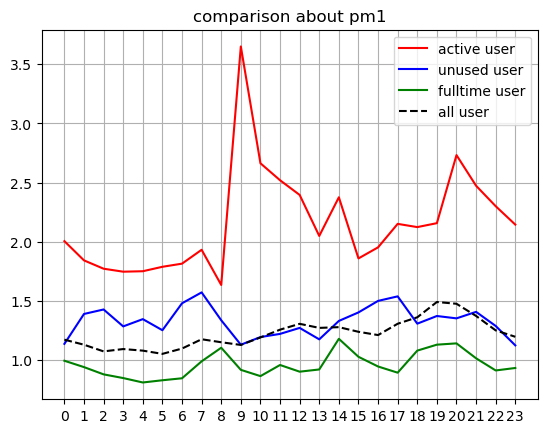

In [83]:
plotting1_time('pm1')

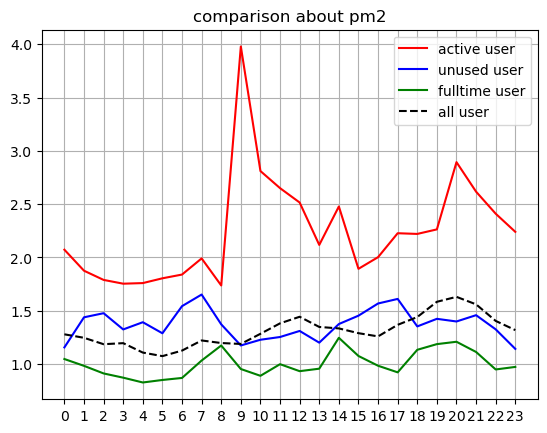

In [84]:
plotting1_time('pm2')

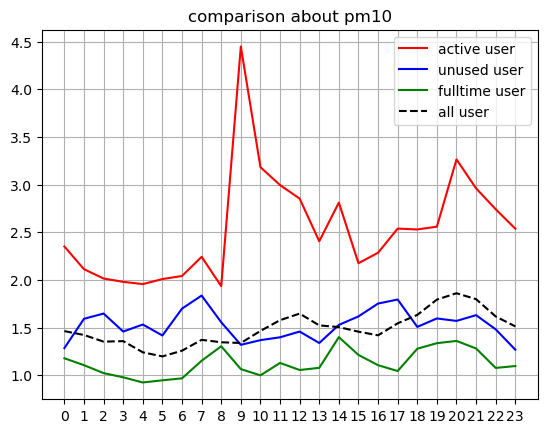

In [85]:
plotting1_time('pm10')

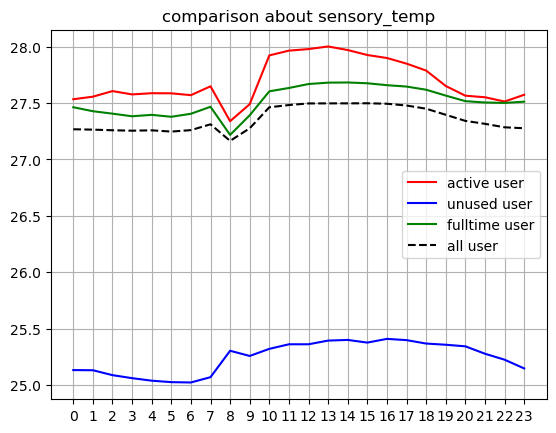

In [86]:
plotting1_time('sensory_temp')

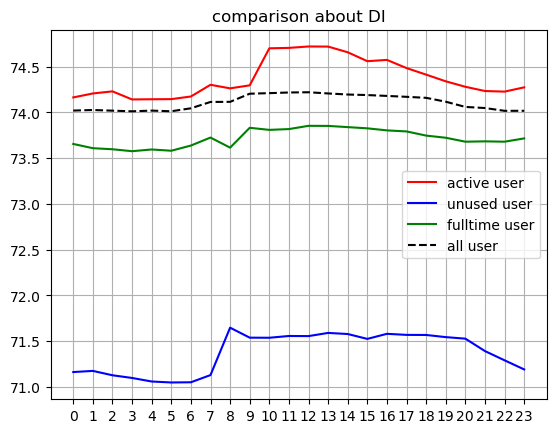

In [87]:
plotting1_time('DI')

In [89]:
print(len(active_user_resampled.loc[active_user_resampled['DI']>=70])/len(smart_dehum_user))
print(len(nonactive_user_resampled.loc[nonactive_user_resampled['DI']>=70])/len(always_dehum_user))
print(len(always_user_resampled.loc[always_user_resampled['DI']>=70])/len(not_dehum_user))

0.006247795636620144
0.0019760116435954913
0.002915291960220371


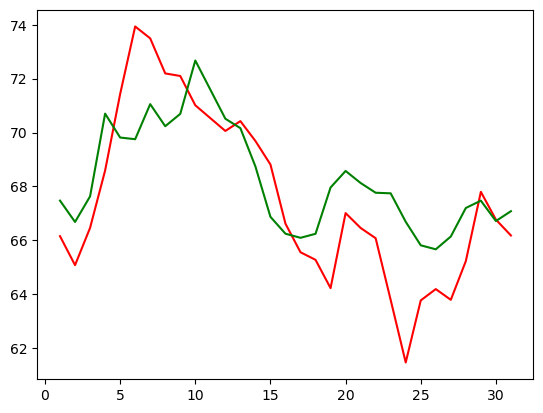

In [48]:
plt.plot(active_user_resampled.groupby('day')['humidity'].mean(),color='r',label='active user')
plt.plot(nonactive_user_resampled.groupby('day')['humidity'].mean(),color='g',label='nonactive user')

In [49]:
active_user_resampled.groupby('hour')['airstate.opmode'].sum()/len(active_user_resampled)

hour
0     0.018817
1     0.018817
2     0.021505
3     0.022849
4     0.022849
5     0.018817
6     0.020161
7     0.018817
8     0.020161
9     0.036290
10    0.016129
11    0.014785
12    0.024194
13    0.022849
14    0.021505
15    0.017473
16    0.024194
17    0.025538
18    0.025538
19    0.017473
20    0.020161
21    0.021505
22    0.018817
23    0.018817
Name: airstate.opmode, dtype: float64

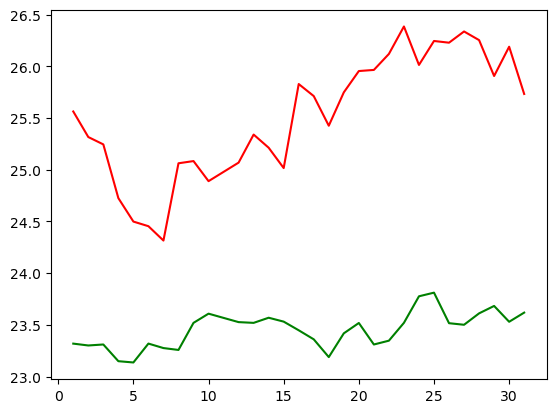

In [50]:
plt.plot(active_user_resampled.groupby('day')['currenttemperature'].mean(),color='r',label='active user')
plt.plot(nonactive_user_resampled.groupby('day')['currenttemperature'].mean(),color='g',label='nonactive user')

In [ ]:
active_user_resampled.groupby('day')['currenttemperature'].mean()

In [ ]:
plt.figure(figsize=(16,8))
always_df2 = always_dehum_user.set_index(['create_dt'])
plt.plot(always_df2.resample('D')['airstate.tempstate.target'].mean(),label = 'always')
not_df2 = not_dehum_user.set_index(['create_dt'])
plt.plot(not_df2.resample('D')['airstate.tempstate.target'].mean(),label='not')
smart_df2 = smart_dehum_user.set_index(['create_dt'])
plt.plot(smart_df2.resample('D')['airstate.tempstate.target'].mean(),label='active')
plt.legend()
plt.show()